In [ ]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='1.' # NOTE: jax preallocates GPU (default 75%)
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from jax import numpy as jnp, random as jr, config as jconfig, devices as jdevices, jit, vmap, grad, debug, tree, lax
jconfig.update("jax_enable_x64", True)
print(jdevices())

# from montecosmo.model import FieldLevelModel, default_config
# from montecosmo.utils import pdump, pload , Path
from pathlib import Path

%matplotlib inline
%load_ext autoreload
%autoreload 2
!hostname
#!jupyter nbconvert --to python /dvs_ro/u1/h/hsimfroy/workspace/montecosmo_proj/src/montecosmo/tests/infer_model2.ipynb

save_dir = Path("./scratch")
# save_dir = Path("/feynman/home/dphp/hs276503/scratch/png/kaiser_test21")
# save_dir = Path("/pscratch/sd/h/hsimfroy/png/kaiser_test21")
save_path = save_dir / "test"
save_dir.mkdir(parents=True, exist_ok=True)

[CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2), CudaDevice(id=3)]
nid001020


/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20250331-1.0.0/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [ ]:
import glob
cosmo, ic, tracer, meshsize, resampler, z = 0, 0, 'LRG', 576, 'ngp', 0.8

fn = {}
outdir = Path(os.getenv('SCRATCH')) / f'bias/{tracer}/z{z:.3f}/AbacusSummit_base_c{cosmo:03d}_ph{ic:03d}/'
fn['catalog_tracer'] = f'/dvs_ro/cfs/cdirs/desi/cosmosim/SecondGenMocks/CubicBox/{tracer}/z{z:.3f}/AbacusSummit_base_c{cosmo:03d}_ph{ic:03d}/LRG_real_space.fits'
fn['mesh_ic'] = f'/dvs_ro/cfs/cdirs/desi/public/cosmosim/AbacusSummit/ic/AbacusSummit_base_c{cosmo:03d}_ph{ic:03d}/ic_dens_N576.asdf'
fns = [glob.glob(f'/dvs_ro/cfs/cdirs/desi/public/cosmosim/AbacusSummit/AbacusSummit_base_c{cosmo:03d}_ph{ic:03d}/halos/z{z:.3f}/{t}_rv_A/{t}_rv_A_*.asdf') for t in ['field', 'halo']]
fn['catalog_particle'] = sorted(sum(fns, []))
fns = fn

In [3]:
# IC
def read_mesh(fn, z=None):
    fn = str(fn)
    import asdf
    with asdf.open(fn) as af:
        growth_table = 1.
        if z is not None:
            growth_table = af['header']['GrowthTable'][z]
        toret = jnp.array(af['data']['density']) * growth_table
    return toret
mesh_ic = read_mesh(fns['mesh_ic'], z=0)
mesh_shape = mesh_ic.shape
print(mesh_shape)
jnp.save(save_dir / 'mesh_ic.npy', mesh_ic)

/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20250331-1.0.0/conda/lib/python3.10/site-packages/asdf/yamlutil.py:355: AsdfConversionWarning: tag:stsci.edu:asdf/core/column-1.0.0 is not recognized, converting to raw Python data structure
  warnings.warn(
/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20250331-1.0.0/conda/lib/python3.10/site-packages/asdf/yamlutil.py:355: AsdfConversionWarning: tag:astropy.org:astropy/table/table-1.0.0 is not recognized, converting to raw Python data structure
  warnings.warn(
/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20250331-1.0.0/conda/lib/python3.10/site-packages/asdf/_asdf.py:294: AsdfPackageVersionWarning: File 'file:///dvs_ro/cfs/cdirs/desi/public/cosmosim/AbacusSummit/ic/AbacusSummit_base_c000_ph000/ic_dens_N576.asdf' was created with extension URI 'asdf://astropy.org/astropy/extensions/astropy-1.0.0' (from package asdf-astropy==0.2.2), which is not currently installed
  w

(576, 576, 576)


In [4]:
from itertools import product

paint_kernels = [
    lambda s: jnp.full(jnp.shape(s)[-1:], jnp.inf), # Dirac
    lambda s: jnp.full(jnp.shape(s)[-1:], 1.), # NGP
    lambda s: 1 - s, # CIC
    lambda s: (s <= 1/2) * (3/4 - s**2) + (1/2 < s) / 2 * (3/2 - s)**2, # TSC
    lambda s: (s <= 1) / 6 * (4 - 6 * s**2 + 3 * s**3) + (1 < s) / 6 * (2 - s)**3, # PCS
]

def paint(pos, mesh:tuple|jnp.ndarray, weights=1., order:int=2):
    """
    Paint the positions onto the mesh. 
    If mesh is a tuple, paint on a zero mesh with such shape.
    """
    if isinstance(mesh, tuple):
        mesh = jnp.zeros(mesh)
    else:
        mesh = jnp.asarray(mesh)

    dtype = 'int16' # int16 -> +/- 32_767, trkl
    shape = np.asarray(mesh.shape, dtype=dtype)
    def wrap(idx):
        return idx % shape
    
    id0 = (jnp.round if order % 2 else jnp.floor)(pos).astype(dtype)
    ishifts = np.arange(order) - (order - 1) // 2
    ishifts = np.array(list(product(* len(shape) * (ishifts,))), dtype=dtype)

    def step(carry, ishift):
        idx = id0 + ishift
        s = jnp.abs(idx - pos)
        idx, ker = wrap(idx), paint_kernels[order](s).prod(-1)

        # idx = jnp.unstack(idx, axis=-1)
        idx = tuple(jnp.moveaxis(idx, -1, 0)) # TODO: JAX >= 0.4.28 for unstack
        carry = carry.at[idx].add(weights * ker)
        return carry, None
    
    mesh = lax.scan(step, mesh, ishifts)[0]
    return mesh


def read(pos, mesh:jnp.ndarray, order:int=2):
    """
    Read the value at the positions from the mesh.
    """
    dtype = 'int16' # int16 -> +/- 32_767, trkl
    shape = np.asarray(mesh.shape, dtype=dtype)
    def wrap(idx):
        return idx % shape
    
    id0 = (jnp.round if order % 2 else jnp.floor)(pos).astype(dtype)
    ishifts = np.arange(order) - (order - 1) // 2
    ishifts = np.array(list(product(* len(shape) * (ishifts,))), dtype=dtype)

    def step(carry, ishift):
        idx = id0 + ishift
        s = jnp.abs(idx - pos)
        idx, ker = wrap(idx), paint_kernels[order](s).prod(-1)

        # idx = jnp.unstack(idx, axis=-1)
        idx = tuple(jnp.moveaxis(idx, -1, 0)) # TODO: JAX >= 0.4.28 for unstack
        carry += mesh[idx] * ker
        return carry, None
    
    out = jnp.zeros(id0.shape[:-1])
    out = lax.scan(step, out, ishifts)[0]
    return out

In [ ]:
# Particle
from abacusnbody.data import read_abacus
from tqdm import tqdm
paint_order = 2
mesh_shape = 3*(576,)
init_mesh = jnp.zeros(mesh_shape)
fin_mesh = jnp.zeros(mesh_shape)
for fn in tqdm(fns['catalog_particle']):
    init_pos = read_abacus.read_asdf(fn.replace('_rv', '_pid'), load=['lagr_pos'])['lagr_pos']
    init_mesh += paint(init_pos, init_mesh, order=paint_order)
    fin_pos = read_abacus.read_asdf(fn, load=['pos'])['pos']
    fin_mesh += paint(fin_pos, fin_mesh, order=paint_order)

jnp.save(save_dir / "init_mesh.npy", init_mesh)
jnp.save(save_dir / "fin_mesh.npy", fin_mesh)

 50%|█████████████████████████                         | 34/68 [06:38<06:41, 11.82s/it]

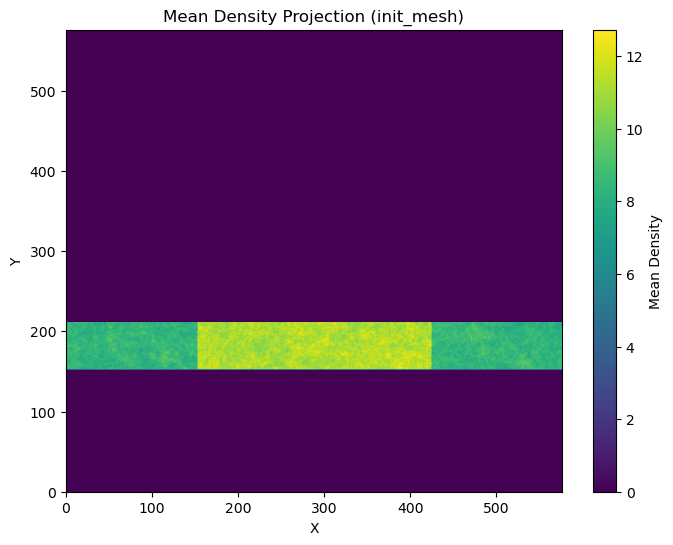

In [10]:
plt.figure(figsize=(8, 6))
plt.pcolormesh(fin_mesh.mean(2))
plt.colorbar(label='Mean Density')
plt.title('Mean Density Projection (init_mesh)')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [ ]:
# Tracer
import fitsio
paint_order = 2
positions = fitsio.read(fns['catalog_tracer'])
positions = np.column_stack([positions[name] for name in ['x', 'y', 'z']])
tracer_mesh = paint(positions, 3*(576,), order=paint_order)
jnp.save(save_dir / 'tracer_mesh.npy', tracer_mesh)
print(positions.min(), positions.max())

(-1000.0, 1000.0)

In [9]:
import plotly.express as px
idx = np.random.choice(positions.shape[0], size=10000, replace=False)
pos = positions[idx]

fig = px.scatter_3d(
    x=pos[:, 0],
    y=pos[:, 1],
    z=pos[:, 2],
    title="Random Sample of 10,000 Positions"
)
fig.update_traces(marker=dict(size=2))
fig.show()

In [12]:
from cosmoprimo.fiducial import AbacusSummit

cosmo = AbacusSummit()
pk_interpolator = cosmo.get_fourier().pk_interpolator().to_1d(z=z)
# pk_interpolator(k)
cosmo.Omega0_cdm

0.26447041034523616